In [1]:
#https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

import glob
import cv2
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Machine_Learning/Crack_Detection') 
!pwd
%ls

/content/drive/MyDrive/Machine_Learning/Crack_Detection
 Autoencoders_Conv2d.ipynb   map.jpg
 data/                       Pos_00045.tif
 data_2/                    'VGG19_Crack_Detection&Localization.ipynb'
 GAN/


In [4]:
#https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
from skimage.color import gray2rgb
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "data_2/"#"Crack_Detection/"
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.tif"):#tif
                self.data.append([img_path, class_name])
        print(len(self.data), self.data[:10])
        self.class_map = {"Negative" : 0, "Positive": 1}
        self.img_dim = (224, 224)   

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        # converting the type of pixel to float 32
        #img = img.astype('float32')
        # normalizing the pixel values
        #img /= 255.0
        #
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(gray2rgb(img))
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        #return img_tensor, class_id
        return img_tensor.float(), class_id.float()

dataset = CustomDataset()
batch_size=64

trainloader = DataLoader(dataset, batch_size, shuffle=True)

['data_2/Positive', 'data_2/Negative']
384 [['data_2/Positive/Pos_00045.tif', 'Positive'], ['data_2/Positive/Pos_00002.tif', 'Positive'], ['data_2/Positive/Pos_00049.tif', 'Positive'], ['data_2/Positive/Pos_00020.tif', 'Positive'], ['data_2/Positive/Pos_00017.tif', 'Positive'], ['data_2/Positive/Pos_00001.tif', 'Positive'], ['data_2/Positive/Pos_00024.tif', 'Positive'], ['data_2/Positive/Pos_00018.tif', 'Positive'], ['data_2/Positive/Pos_00041.tif', 'Positive'], ['data_2/Positive/Pos_00012.tif', 'Positive']]


In [5]:
class VGG(nn.ModuleList):
    def __init__(self):
        super(VGG, self).__init__()
        #self.bs = batch_size
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.before_classifier = nn.Sequential(nn.Linear(in_features=7*7*512, out_features=1000), nn.ReLU(True), nn.Dropout(0.5), nn.Linear(in_features=1000, out_features=2)) #, nn.Sigmoid()#self.vgg.classifier
        self.classifier = nn.Sequential(nn.Linear(in_features=2, out_features=1), nn.Sigmoid()) ##self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x1 = self.before_classifier(x)
        x2 = self.classifier(x1)
        return x1,x2
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
       return self.features_conv(x)

In [6]:
#model.compile(optimizer= Adam(lr=0.0001), loss = "BinaryCrossentropy", metrics = ['acc'])

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

# initialize the VGG model
vgg = VGG()
vgg.to(device)
print(vgg)
from torchsummary import summary
summary(vgg,(3,224,224))

#Loss function
criterion = torch.nn.BCELoss()#BCEWithLogitsLoss()#

#Optimizer
optimizer = torch.optim.SGD(vgg.parameters(), lr=0.0001, momentum=0.9)

cuda:0


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Conv2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
#Optimizer
optimizer = torch.optim.SGD(vgg.parameters(), lr=0.00005, momentum=0.9)

In [36]:
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor if device == 'cuda:0' else torch.FloatTensor

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs, labels = Variable(inputs), Variable(labels)
        inputs.to(device)
        labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        _,output = vgg(inputs.type(Tensor))
        #outputs = torch.tensor(output.argmax(dim=1), dtype = torch.float)

        loss = criterion(output, labels.type(Tensor))
        #loss.requres_grad = True

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2 == 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0

print('Finished Training')

[1,     2] loss: 0.000017
[1,     4] loss: 0.000020
[1,     6] loss: 0.000024
[2,     2] loss: 0.000025
[2,     4] loss: 0.000016
[2,     6] loss: 0.000021
[3,     2] loss: 0.000017
[3,     4] loss: 0.000022
[3,     6] loss: 0.000022
[4,     2] loss: 0.000026
[4,     4] loss: 0.000017
[4,     6] loss: 0.000019
[5,     2] loss: 0.000020
[5,     4] loss: 0.000022
[5,     6] loss: 0.000019
[6,     2] loss: 0.000021
[6,     4] loss: 0.000016
[6,     6] loss: 0.000025
[7,     2] loss: 0.000020
[7,     4] loss: 0.000021
[7,     6] loss: 0.000020
[8,     2] loss: 0.000018
[8,     4] loss: 0.000021
[8,     6] loss: 0.000022
[9,     2] loss: 0.000019
[9,     4] loss: 0.000021
[9,     6] loss: 0.000021
[10,     2] loss: 0.000023
[10,     4] loss: 0.000016
[10,     6] loss: 0.000021
[11,     2] loss: 0.000018
[11,     4] loss: 0.000024
[11,     6] loss: 0.000019
[12,     2] loss: 0.000018
[12,     4] loss: 0.000025
[12,     6] loss: 0.000018
[13,     2] loss: 0.000023
[13,     4] loss: 0.000023
[

In [37]:
# set the evaluation mode
vgg.eval()

# get the image from the dataloader
#img, _ = next(iter(trainloader))
#pred = vgg(img)

img = cv2.imread("Pos_00100.tif")
img = cv2.resize(img, (224, 224) )
img_tensor = torch.from_numpy(gray2rgb(img))
#print(img_tensor.shape[0], img_tensor.shape[1], img_tensor.shape[2])
img_tensor = img_tensor.permute(2, 0, 1)
#print(img_tensor.shape[0], img_tensor.shape[1], img_tensor.shape[2])
img_tensor = img_tensor.unsqueeze(0)
#print(img_tensor.shape[0], img_tensor.shape[1], img_tensor.shape[2], img_tensor.shape[3])
img_tensor.to(device)

# get the most likely prediction of the model
pred1, pred2 = vgg(img_tensor.type(torch.cuda.FloatTensor))
print(pred1, pred2)

tensor([[20.2453,  7.9274]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [38]:
# get the gradient of the output with respect to the parameters of the model
#Active = torch.nn.Sequential(*list(vgg.children())[:-1])
#final_layer = list(vgg.children())[-1]

pred1[:, 1].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img_tensor.type(torch.cuda.FloatTensor)).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

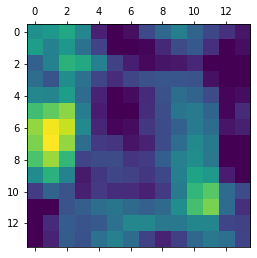

In [39]:
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu(), 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [40]:
print(img_tensor.shape[2], img_tensor.shape[3])
heatmap = cv2.resize(np.float32(heatmap), (img_tensor.shape[2], img_tensor.shape[3]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.3 + img
cv2.imwrite('./map.jpg', superimposed_img)

224 224


True

In [ ]:
for epoch in range(0):  # loop over the dataset multiple times

    train_loss = 0.0

    for data in trainloader:

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs.to(device)
        labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg(inputs.type(torch.cuda.FloatTensor))

        loss = criterion(outputs, (labels.type(torch.cuda.FloatTensor)))
        loss.backward()

        optimizer.step()

        train_loss += loss.item()*inputs.size(0)
          
    train_loss = train_loss/len(trainloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

print('Finished Training')